In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from flows import *
from utl import *
from load_data import *
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# Hypter parameters
K = 6  # length of the flow
learning_rate = 1e-3
iterrations = 1e5

In [3]:
DTYPE=tf.float32
NP_DTYPE=np.float32
num_bijectors = 4
n_epochs = 1000
lr = 1e-3

In [4]:
# constants
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

## Target Density

(-2.0, 2.0)

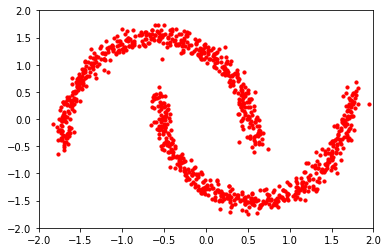

In [5]:
X_data = load_moon_dataset()
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X_data[:, 0], X_data[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

## Construct Flow

### Step 1. Define Invertible leaky rectified linear transformation

In [6]:
class PReLU(tfb.Bijector):
    def __init__(self, alpha=0.5):
        super().__init__(forward_min_event_ndims=0)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(x>=0, x, x*self.alpha)

    def _inverse(self, y):
        return tf.where(y>=0, y, y/self.alpha)

    def _inverse_log_det_jacobian(self, y):
        return tf.math.log(tf.where(y>=0, 1., 1./self.alpha))

### Step 2. Define MLP Normalizing Flow

In [7]:
def mlp_flow(input_dims, num_bijectors):
    # base distribution
    base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32), scale_diag=tf.ones([2], tf.float32))
    d = input_dims
    bijectors = []
    
    for i in range(num_bijectors):
        scale = tf.Variable(tf.random.normal(shape=[d, d]), dtype=tf.float32)
        shift = tf.Variable(tf.random.normal(shape=[d]), dtype=tf.float32)
        scale_tril = tf.Variable(tf.random.normal(shape=[int(d * (d+1) / 2)]), dtype=tf.float32)
        alpha = tf.abs(tf.Variable(tf.random.normal(shape=[1]), dtype=tf.float32)) + .01

        bijector = tfb.Affine(
            scale_tril=tfp.math.fill_triangular(scale_tril),
            scale_perturb_factor=scale,
            shift=shift)
        bijectors.append(bijector)

        bijectors.append(PReLU(alpha=alpha))

    mlp_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
    flow = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=mlp_bijector,
        validate_args=True
    )
    return flow

In [8]:
flow = mlp_flow(2, num_bijectors)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32), scale_diag=tf.ones([2], tf.float32))
names, samples = make_samples(base_dist, flow)

Instructions for updating:
`Affine` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Matvec*)` where `tfb.Matvec*` is one of `MatvecDiag`, `MatvecTriL`, or `MatvecLinearOperator`.
Instructions for updating:
Do not call `graph_parents`.


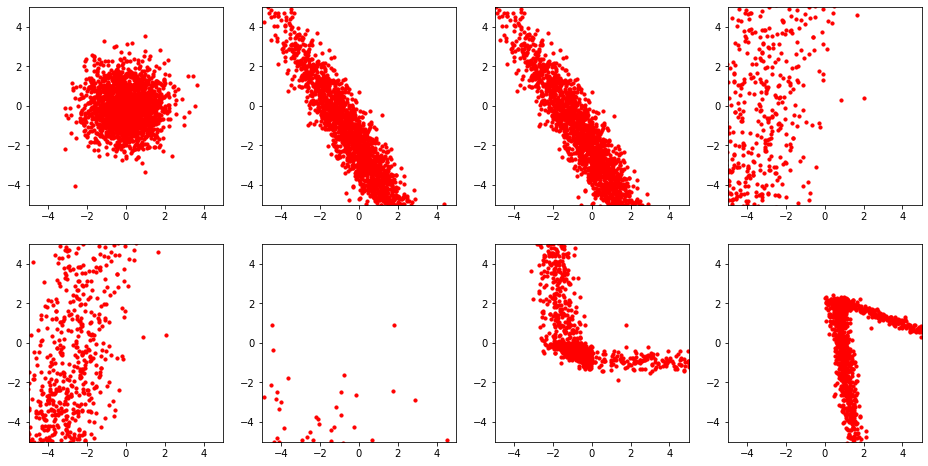

In [9]:
plot_samples(samples, names, rows=2)

In [11]:
history = train_dist_routine(X_data, flow, n_epochs=n_epochs, n_disp=int(n_epochs/50))

ValueError: Fill dimensions must be >= 0 for '{{node ones}} = Fill[T=DT_FLOAT, index_type=DT_INT32](tf.concat/concat, ones/Const)' with input shapes: [2], [] and with input tensors computed as partial shapes: input[0] = [2,?].